In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

import evaluate
from model import LSTM
from trainer import BenchmarkTrainer
from dataloader import GraphEnv, DataLoader, preprocess_zero_shot_dataset

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_random_seed(70)

In [3]:
n_nodes = 9
n_obs = 9
trajectory_length = 16  # numer of node visits in a trajectory
num_desired_trajectories= 30

env = GraphEnv(
    n_items=n_nodes,                     # number of possible observations
    env='grid', 
    batch_size=trajectory_length, 
    num_desired_trajectories=num_desired_trajectories, 
    device=None, 
    unique=True,                         # each state is assigned a unique observation if true
    args = {"rows": 3, "cols": 3}
)

train_dataset = env.gen_dataset()
test_dataset = env.gen_dataset()

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [9]:
hidden_dim = 10
epochs = 200
include_init_state_info = False

model = LSTM(env.n_items, env.n_actions, env.size, hidden_dim, include_init_state_info=include_init_state_info)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

trainer = BenchmarkTrainer(
    model,
    train_dataloader,
    torch.optim.Adam(model.parameters()),
    torch.nn.CrossEntropyLoss(),
    test_loader=test_dataloader,
    include_init_state_info=include_init_state_info,
    reset_every=2
)

losses, model = trainer.train(epochs)

1099


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0, 'Epochs')

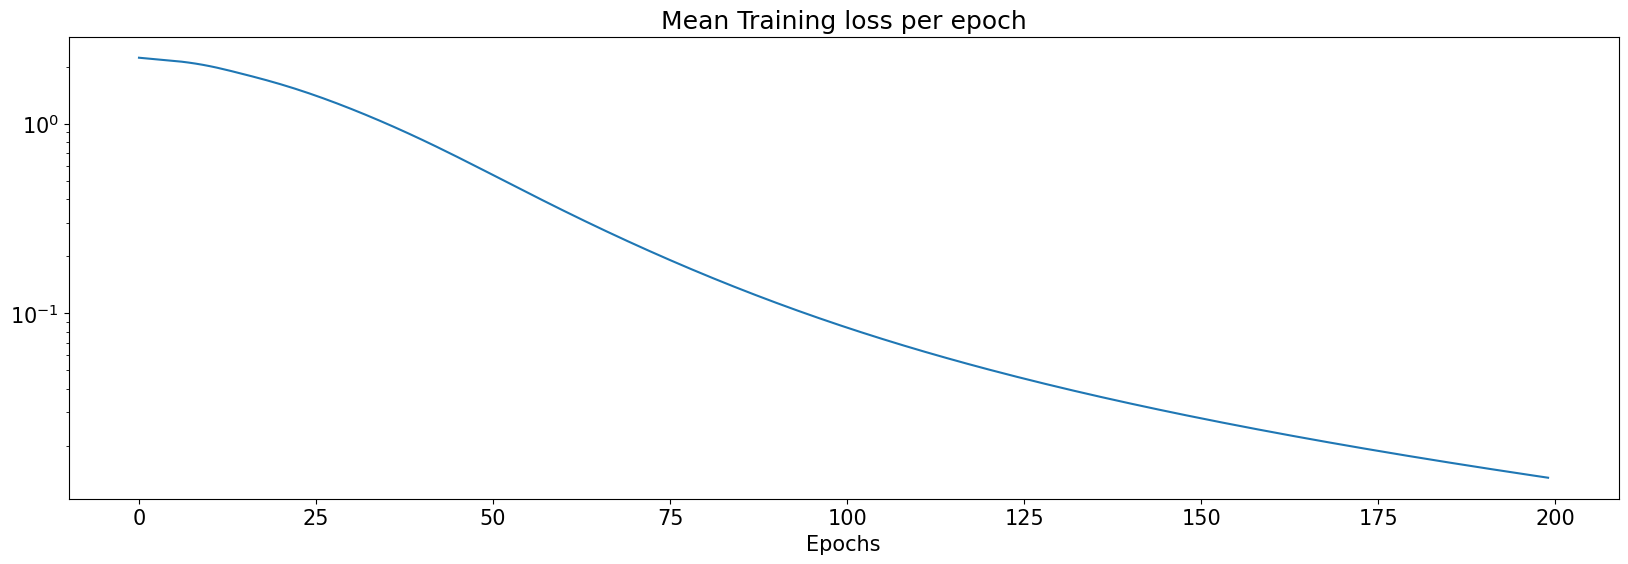

In [10]:
plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(losses, axis=1))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

In [11]:
train_acc, train_conf = evaluate.benchmark_accuracy(model, trainer.train_dataset)
test_acc, test_conf = evaluate.benchmark_accuracy(model, trainer.test_dataset)
print("Train acc/conf: ", train_acc, np.mean(train_conf))
print("Test acc/conf: ", test_acc, np.mean(test_conf))

Train acc/conf:  1.0 0.99734510951572
Test acc/conf:  1.0 0.9972511332564884


In [14]:
dataset = env.gen_zero_shot_dataset(trajectory_length=30, num_environments=50)
dataset = preprocess_zero_shot_dataset(model, dataset, include_init_state_info=include_init_state_info)

In [15]:
evaluate.zero_shot_accuracy_benchmark(model, dataset)

tensor(0.0876)